# ChainerPainter - Image Regression in Chainer



Inspired by the following brilliant works: 

[ConnetJS demo: Image "Painting"](http://cs.stanford.edu/people/karpathy/convnetjs/demo/image_regression.html) 
by [@karpathy](http://twitter.com/karpathy) 

[Neural Network Generative Art in Javascript](http://blog.otoro.net/2015/06/19/neural-network-generative-art/) by [@hardmaru](http://twitter.com/hardmaru)

In [ ]:
# chainer
import numpy as np
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList

# utilities
from cStringIO import StringIO
from IPython.display import clear_output, Image, display
from scipy.misc import imresize
import PIL.Image
import random as rnd

def show_img_array(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))  

def to_np(imgpath):
    return np.float32(PIL.Image.open(imgpath))

# using GPU or not
gpu_flag = 0

if gpu_flag >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_flag >= 0 else np


## 1st Example with very simple network

8-fully connected layers. Each layer has 20 neurons. ReLU activation.  

input layer: x-y coordinate (2 dimention)  
output layer: RGB colro output (3 dimention) 

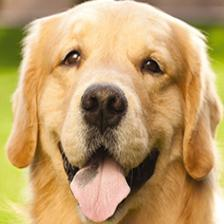

In [30]:
# 1st example
w  = 224
img = imresize(to_np("dog.jpg"), (w,w))
show_img_array(img)

In [7]:
def get_training_data(img):
    # need to polish! i know this is not quite Python-ish... 
    indices = []
    rgbs = []
    w = img.shape[0]
    for i in range(w):
        for j in range(w):
            _s = float(w)
            x = (i - _s/2.0)/_s
            y = (j - _s/2.0)/_s
            rgb = img[i, j]
            indices.append([x, y])
            rgbs.append(rgb)
    indices = xp.array(indices,dtype=np.float32)
    rgb = xp.array(rgbs,dtype=np.float32)

    x_data = Variable(indices)
    y_data = Variable(rgb/255.0 - 0.5)
    return x_data, y_data

x_data, y_data = get_training_data(img)

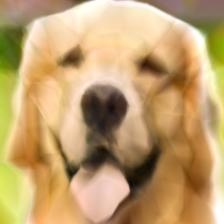

In [43]:
# training
model = chainer.Chain(l1=L.Linear(2, 20, wscale=2),             
                            l2=L.Linear(20, 20, wscale=1),
                            l3=L.Linear(20, 20, wscale=2),
                            l4=L.Linear(20, 20, wscale=1),
                            l5=L.Linear(20, 20, wscale=2),
                            l6=L.Linear(20, 20, wscale=1),
                            l7=L.Linear(20, 20, wscale=1),
                            l8=L.Linear(20, 20, wscale=1), 
                            l13=L.Linear(20, 3, wscale=2))              

if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model.to_gpu()
    
def forward(model, x, t):
    h = F.relu(model.l1(x))
    h = F.relu(model.l2(h))
    h = F.relu(model.l3(h))
    h = F.relu(model.l4(h))
    h = F.relu(model.l5(h))
    h = F.relu(model.l6(h))
    h = F.relu(model.l7(h))
    h = F.relu(model.l8(h))
    h = model.l13(h)
    return  F.mean_squared_error(h, t), h

optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(model)

for i in range(1000000):
    optimizer.zero_grads()
    loss, h = forward(model, x_data, y_data)
    loss.backward()
    optimizer.update()    
    
    if i % 30 == 0:
        img2 = cuda.to_cpu(h.data)
        img2 = img2.reshape((s,s,3))
        show_img_array((img2 + 0.5)* 255.)
        clear_output(wait=True)


In [44]:
serializers.save_hdf5('painter.model', model)

### now things get more interesting 
Let's see what happens if you drop some of hidden layers randomly when you feed x-y coordinate data

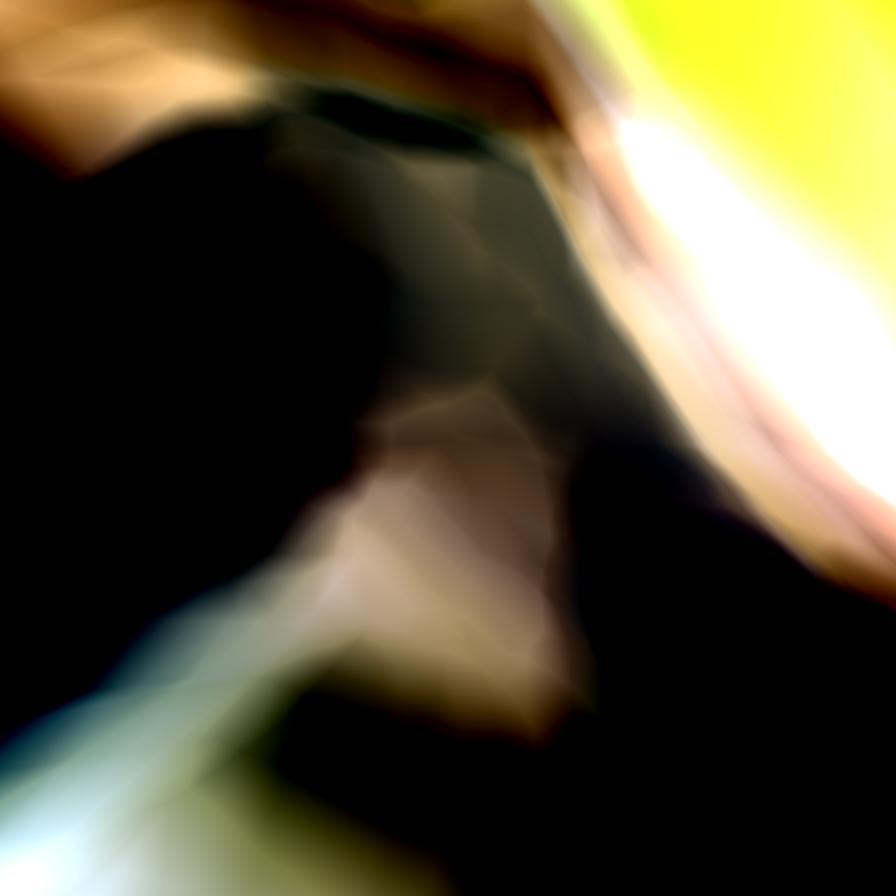

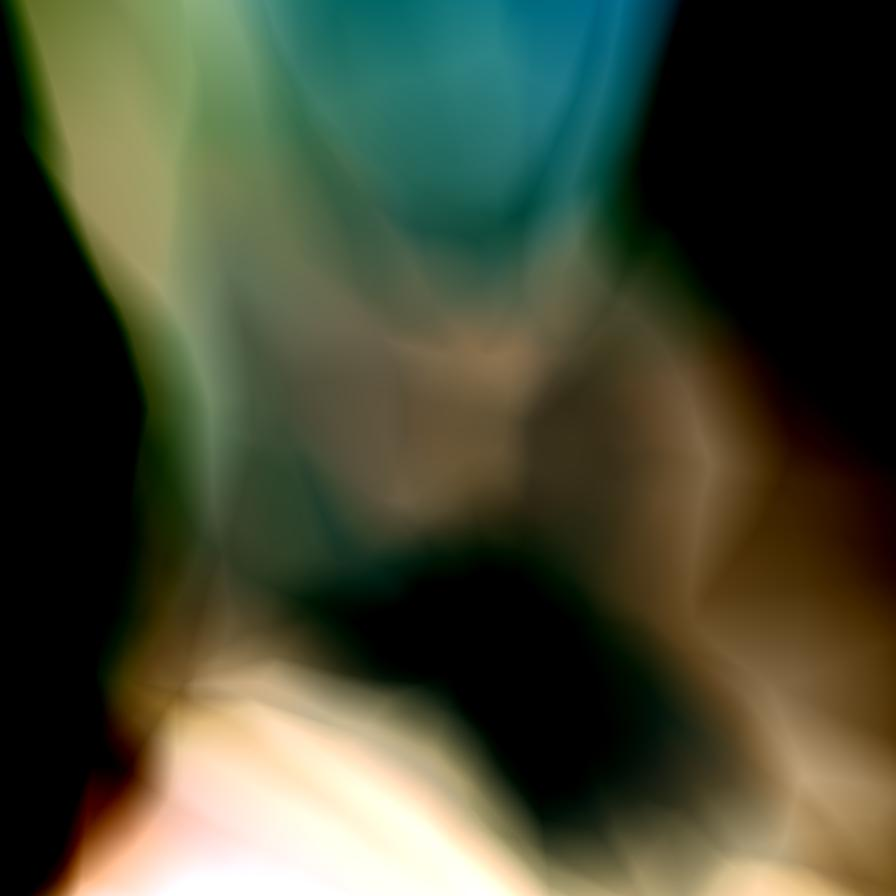

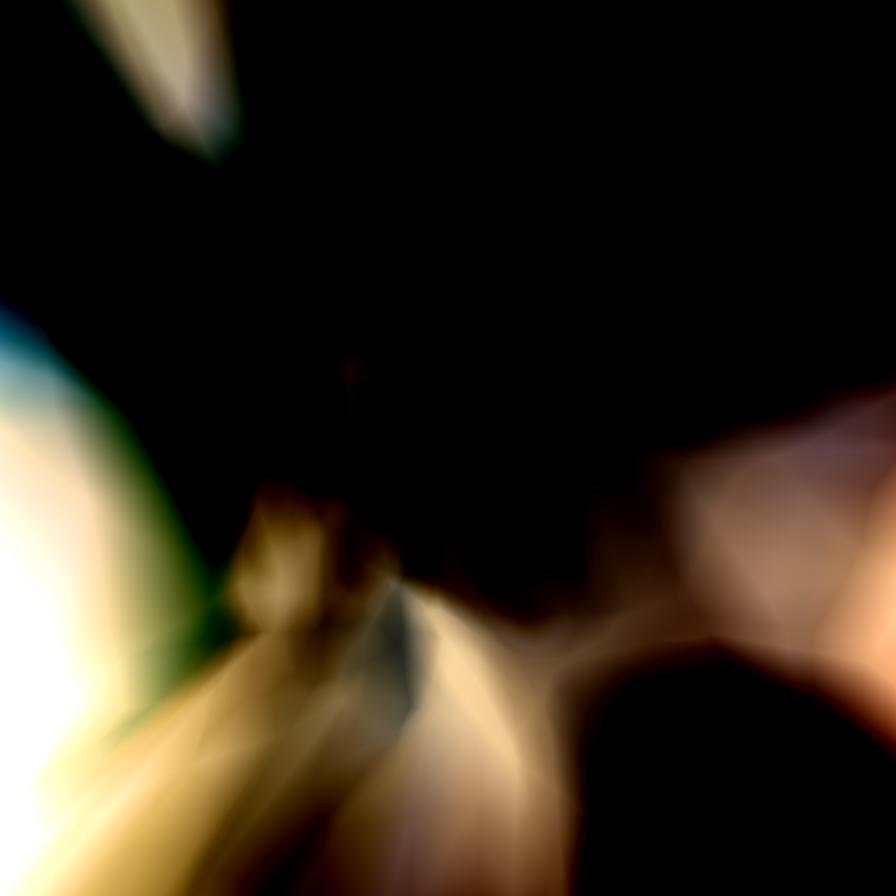

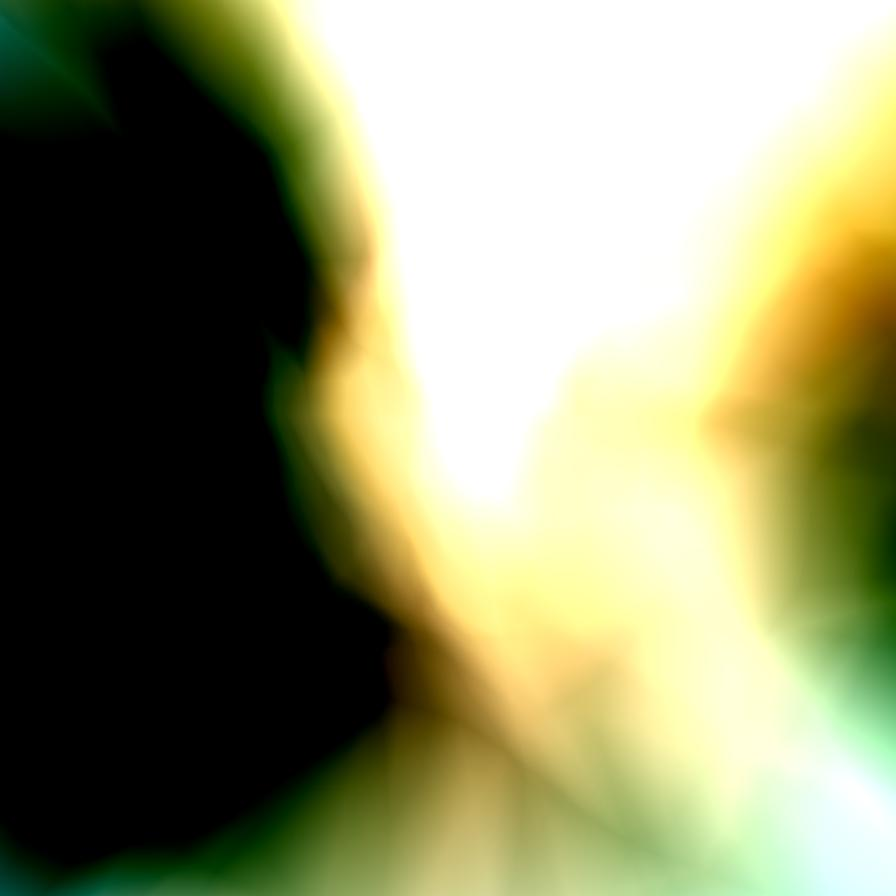

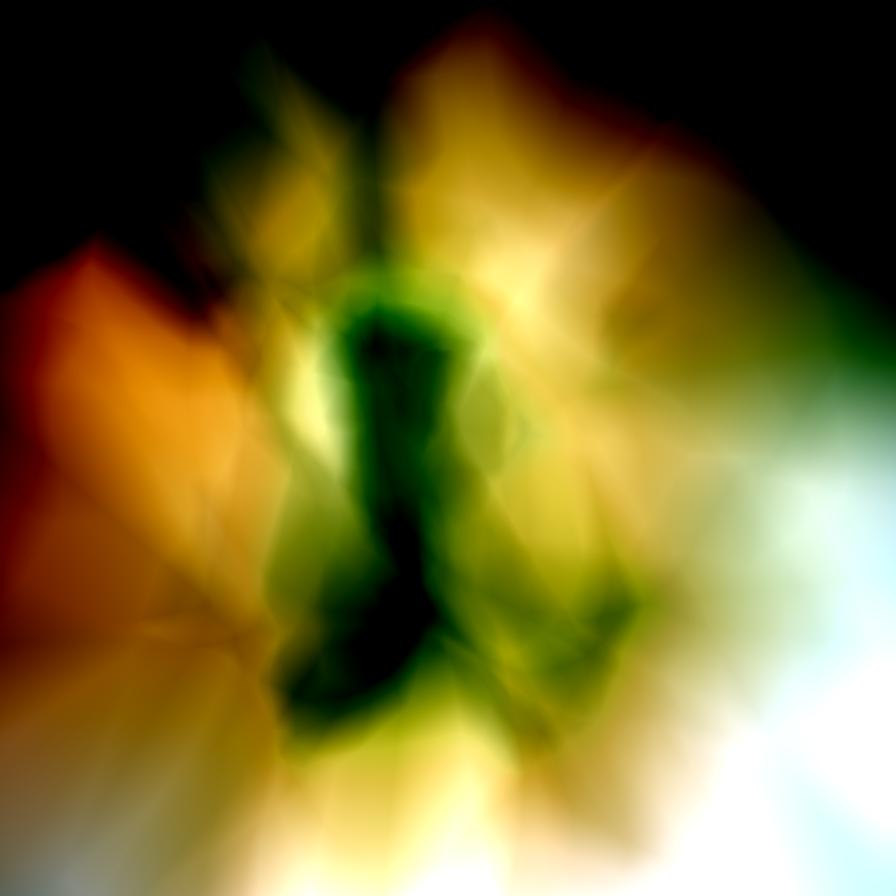

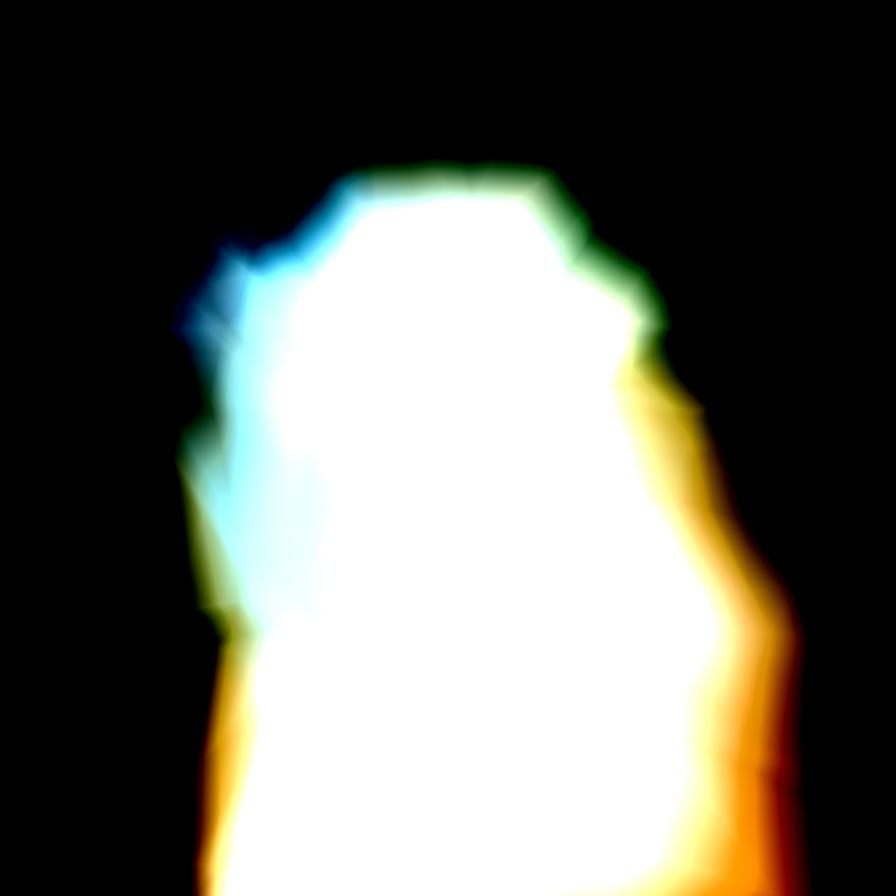

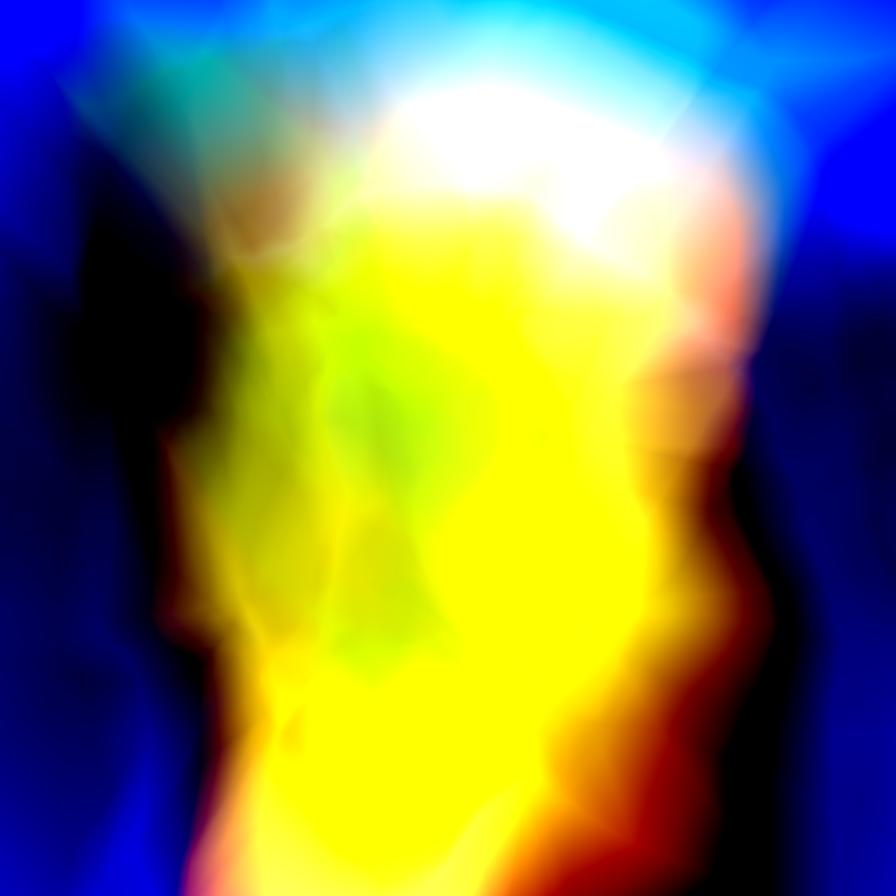

In [108]:
# scale input xy coordinate so that you get bigger 
def get_scaled_indices(img, scale):
    indices = []
    w = img.shape[0]
    s = int(w * scale)
    for i in range(s):
        for j in range(s):
            _s = float(s)
            x = (i - _s/2.0)/_s
            y = (j - _s/2.0)/_s
            indices.append([x, y])
    indices = xp.array(indices,dtype=np.float32)
    x_data = Variable(indices)

    return x_data, s
x_data_scaled, s = get_scaled_indices(img, 4.0)

def activate(h, f, droprate):
    r = rnd.random()
    return F.relu(f(h)) if r > droprate else h

def forward3(x, i):
    h = F.relu(model.l1(x))
    droprate = 0
    if (i!=0): h = activate(h, model.l2, droprate) # again this is very quick hack. not Pythonish
    if (i!=1): h = activate(h, model.l3, droprate)
    if (i!=2): h = activate(h, model.l4, droprate)
    if (i!=3): h = activate(h, model.l5, droprate)
    if (i!=4): h = activate(h, model.l6, droprate)
    if (i!=5): h = activate(h, model.l7, droprate)
    if (i!=6): h = activate(h, model.l8, droprate)
    h = model.l13(h)
    return  h

for i in range(7):
    h = forward3(x_data_scaled, i)
    img2 = cuda.to_cpu(h.data)
    img2 = img2.reshape((s,s,3))
    show_img_array((img2 + 0.5)* 255.)

## 2nd Example with relatively more complex network

8-fully connected layers. Each layer has 40 neurons. ReLU activation.  


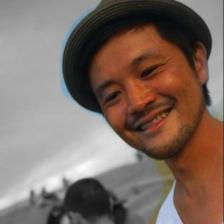

In [22]:
# 2nd example
img = imresize(to_np("nao.jpg"), (w,w)) # yeah, it's me! 
show_img_array(img)
s = img.shape[0]
x_data, y_data = get_training_data(img)

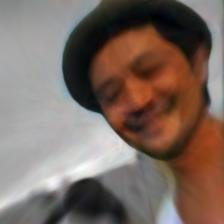

In [23]:
model2 = chainer.Chain(l1=L.Linear(2, 40, wscale=2),  # just a little bit more complex model       
                            l2=L.Linear(40, 40, wscale=1),
                            l3=L.Linear(40, 40, wscale=2),
                            l4=L.Linear(40, 40, wscale=1),
                            l5=L.Linear(40, 40, wscale=2),
                            l6=L.Linear(40, 40, wscale=1),
                            l7=L.Linear(40, 40, wscale=1),
                            l8=L.Linear(40, 40, wscale=1), 
                            l13=L.Linear(40, 3, wscale=2))              

if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model2.to_gpu()
    
optimizer2 = optimizers.SGD(lr=0.01)
optimizer2.setup(model2)

def forward(model, x, t):
    h = F.relu(model.l1(x))
    h = F.relu(model.l2(h))
    h = F.relu(model.l3(h))
    h = F.relu(model.l4(h))
    h = F.relu(model.l5(h))
    h = F.relu(model.l6(h))
    h = F.relu(model.l7(h))
    h = F.relu(model.l8(h))
    h = model.l13(h)
    return  F.mean_squared_error(h, t), h

for i in range(1000000):
    optimizer2.zero_grads()
    loss, h = forward(model2, x_data, y_data)
    loss.backward()
    optimizer2.update()    
    
    if i % 30 == 0:
        img2 = cuda.to_cpu(h.data)
        img2 = img2.reshape((s,s,3))
        show_img_array((img2 + 0.5)* 255.)
        clear_output(wait=True)

In [31]:
serializers.save_hdf5('painter2.model', model2)

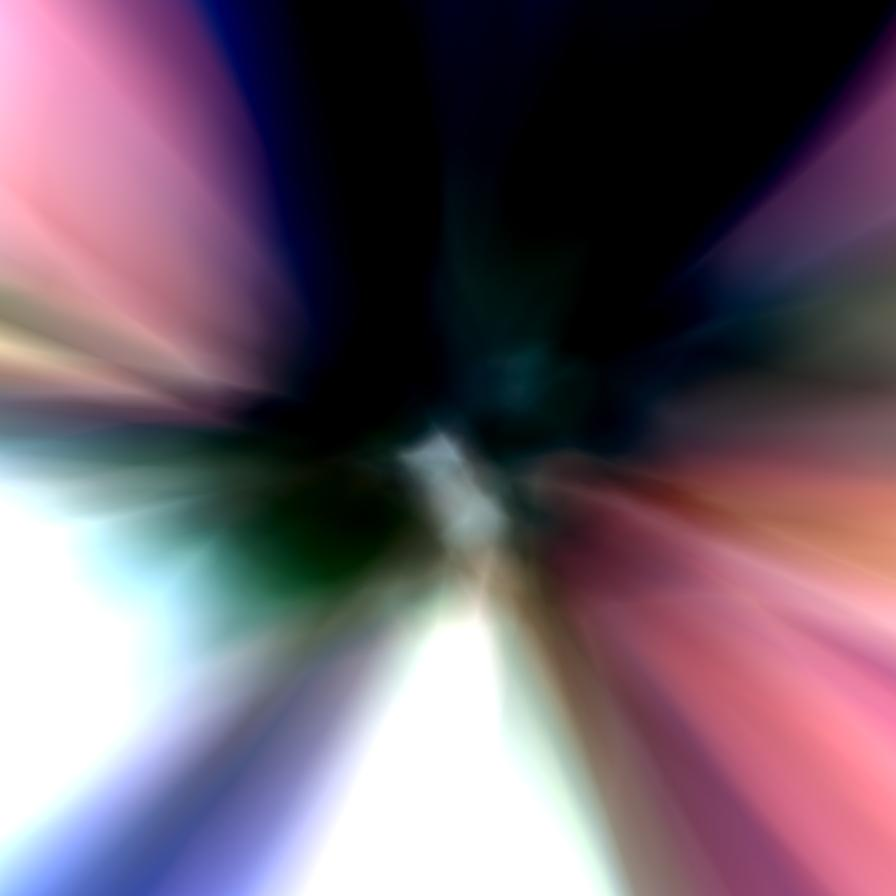

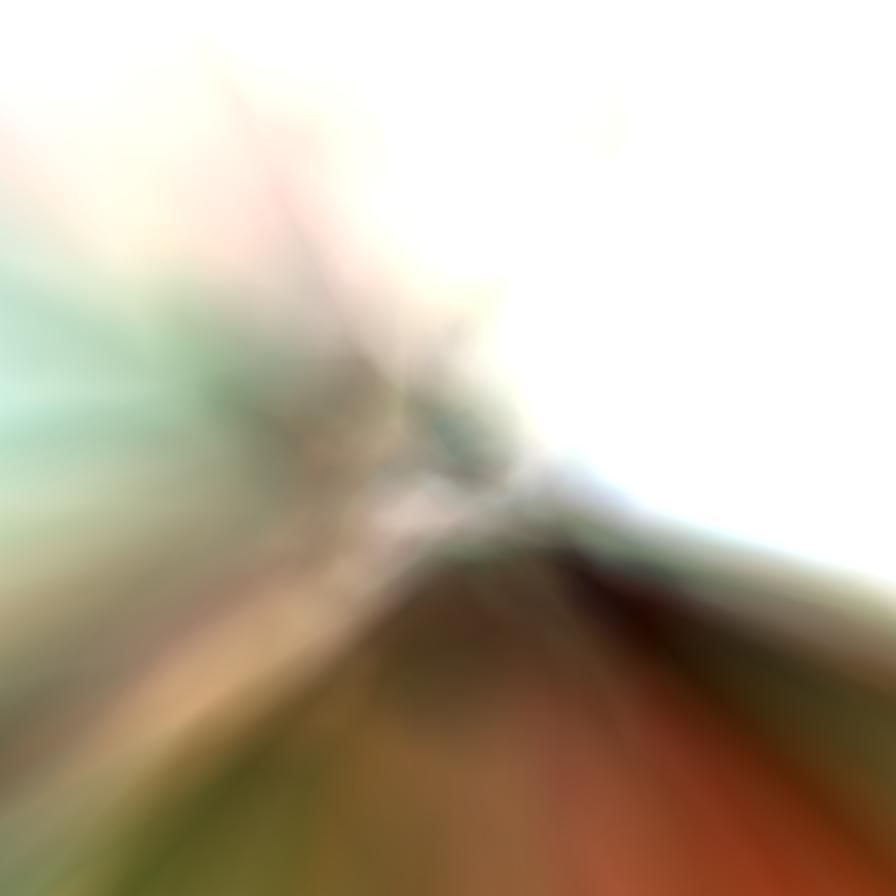

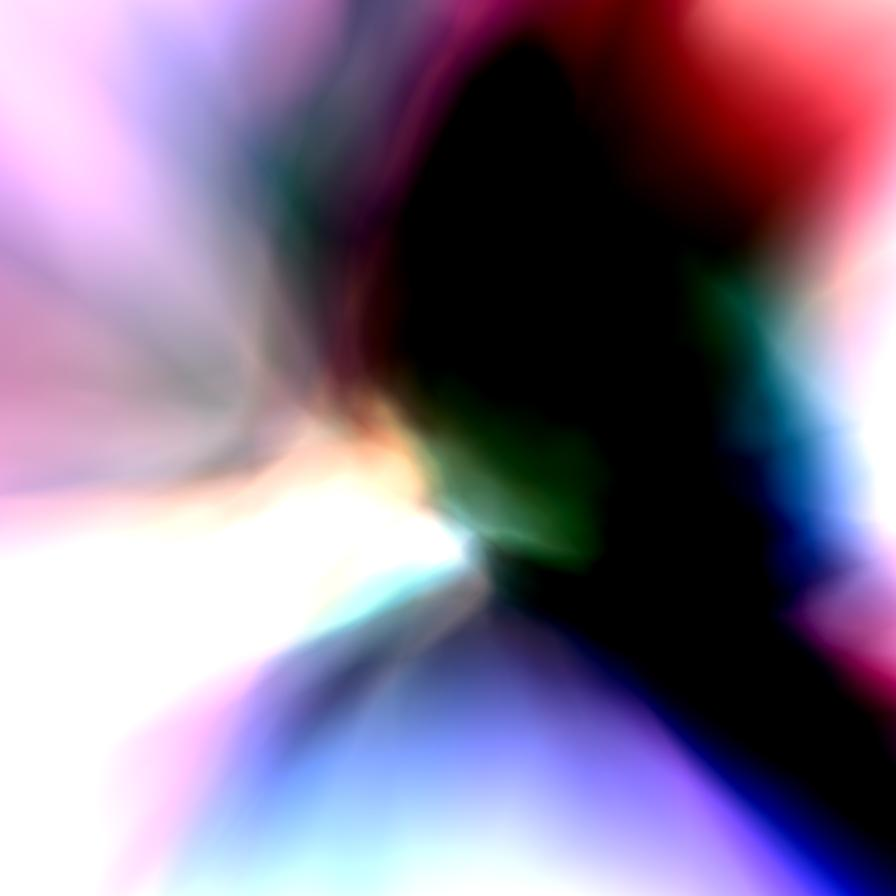

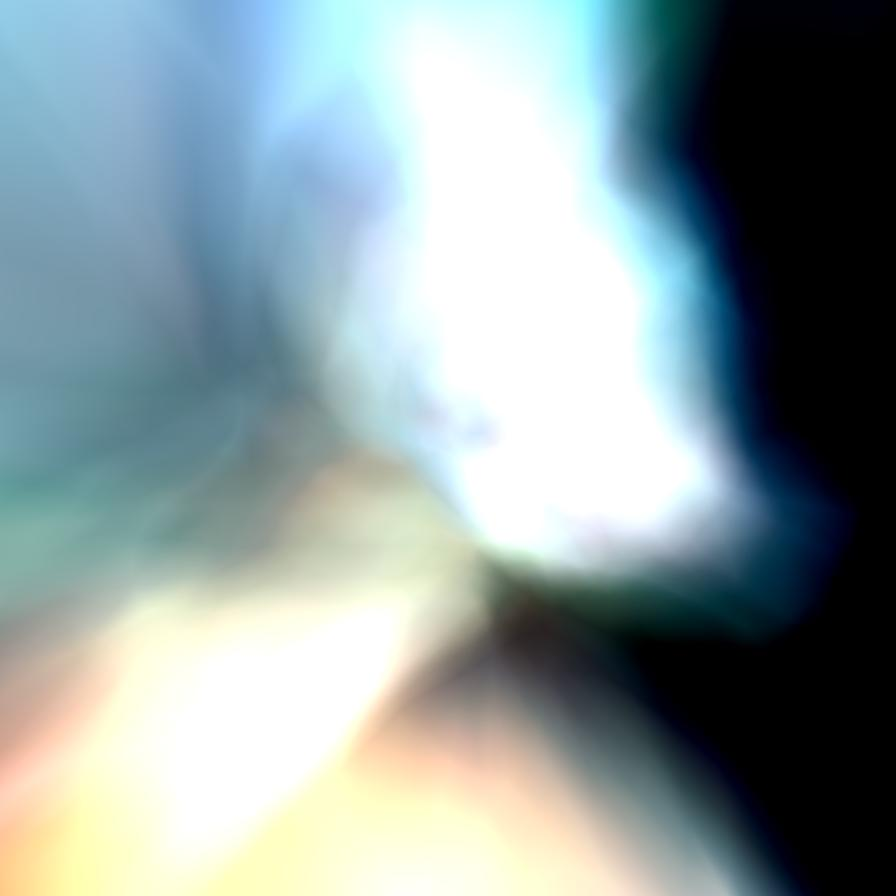

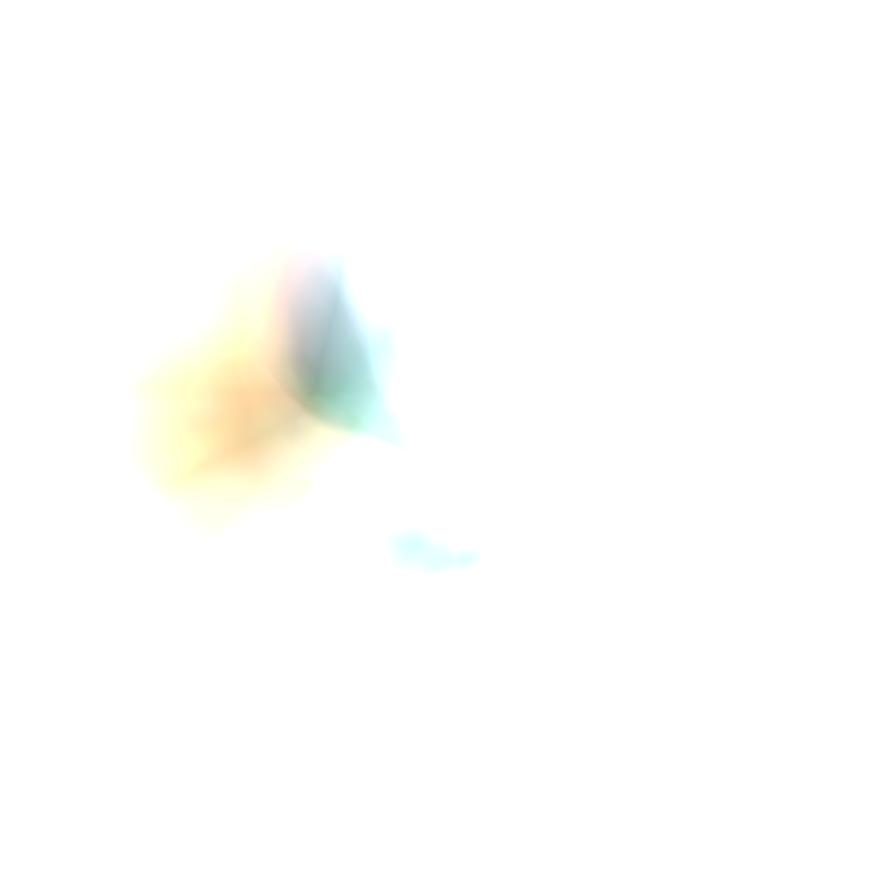

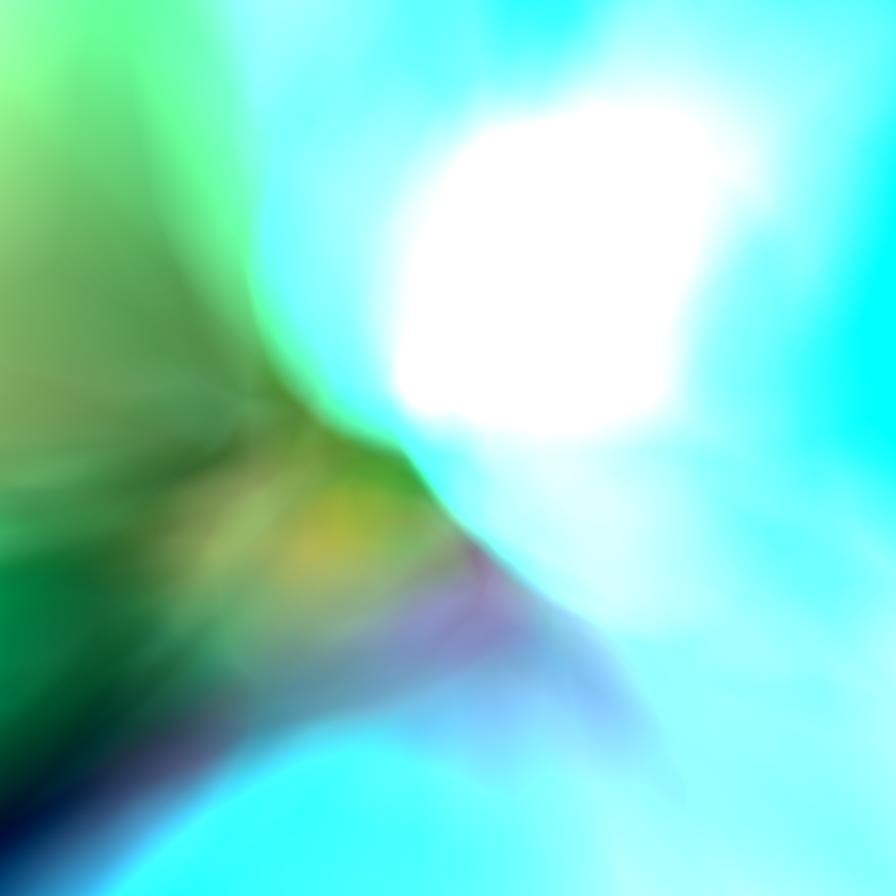

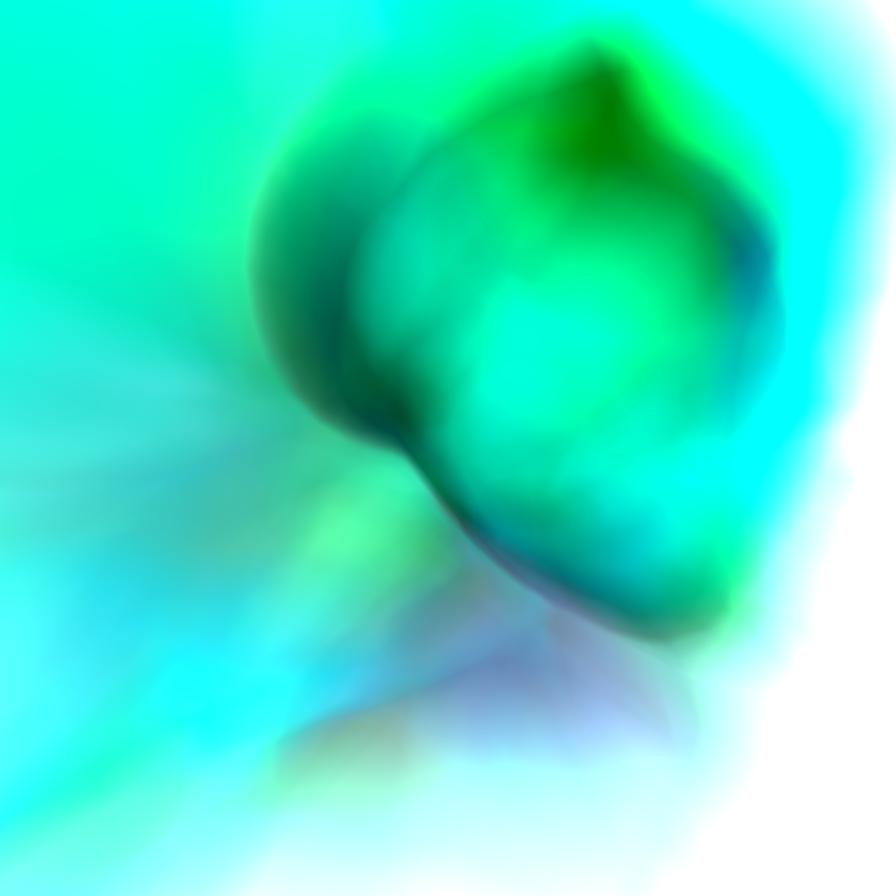

In [24]:
# scale input xy coordinate so that you get bigger 
def get_scaled_indices(img, scale):
    indices = []
    w = img.shape[0]
    s = int(w * scale)
    for i in range(s):
        for j in range(s):
            _s = float(s)
            x = (i - _s/2.0)/_s
            y = (j - _s/2.0)/_s
            indices.append([x, y])
    indices = xp.array(indices,dtype=np.float32)
    x_data = Variable(indices)

    return x_data, s
x_data_scaled, s = get_scaled_indices(img, 4.0)

def activate(h, f, droprate):
    r = rnd.random()
    return F.relu(f(h)) if r > droprate else h

def forward2(x, droprate = 0.10):
    h = F.relu(model2.l1(x))
    h = activate(h, model2.l2, droprate)
    h = activate(h, model2.l3, droprate)
    h = activate(h, model2.l4, droprate)
    h = activate(h, model2.l5, droprate)
    h = activate(h, model2.l6, droprate)
    h = activate(h, model2.l7, droprate)
    h = activate(h, model2.l8, droprate)
    h = model2.l13(h)
    return  h


def forward3(x, i):
    h = F.relu(model2.l1(x))
    droprate = 0
    if (i!=0): h = activate(h, model2.l2, droprate) # again this is very quick hack. not Pythonish
    if (i!=1): h = activate(h, model2.l3, droprate)
    if (i!=2): h = activate(h, model2.l4, droprate)
    if (i!=3): h = activate(h, model2.l5, droprate)
    if (i!=4): h = activate(h, model2.l6, droprate)
    if (i!=5): h = activate(h, model2.l7, droprate)
    if (i!=6): h = activate(h, model2.l8, droprate)
    h = model2.l13(h)
    return  h


for i in range(7):
    h = forward3(x_data_scaled, i)
    img2 = cuda.to_cpu(h.data)
    img2 = img2.reshape((s,s,3))
    show_img_array((img2 + 0.5)* 255.)

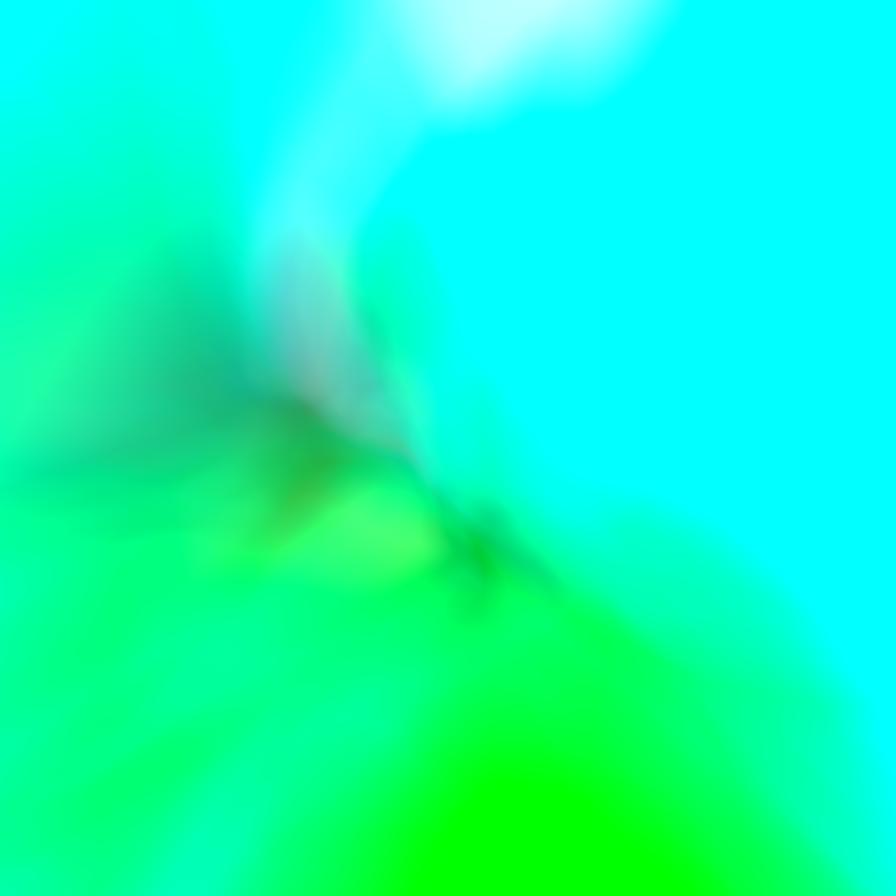

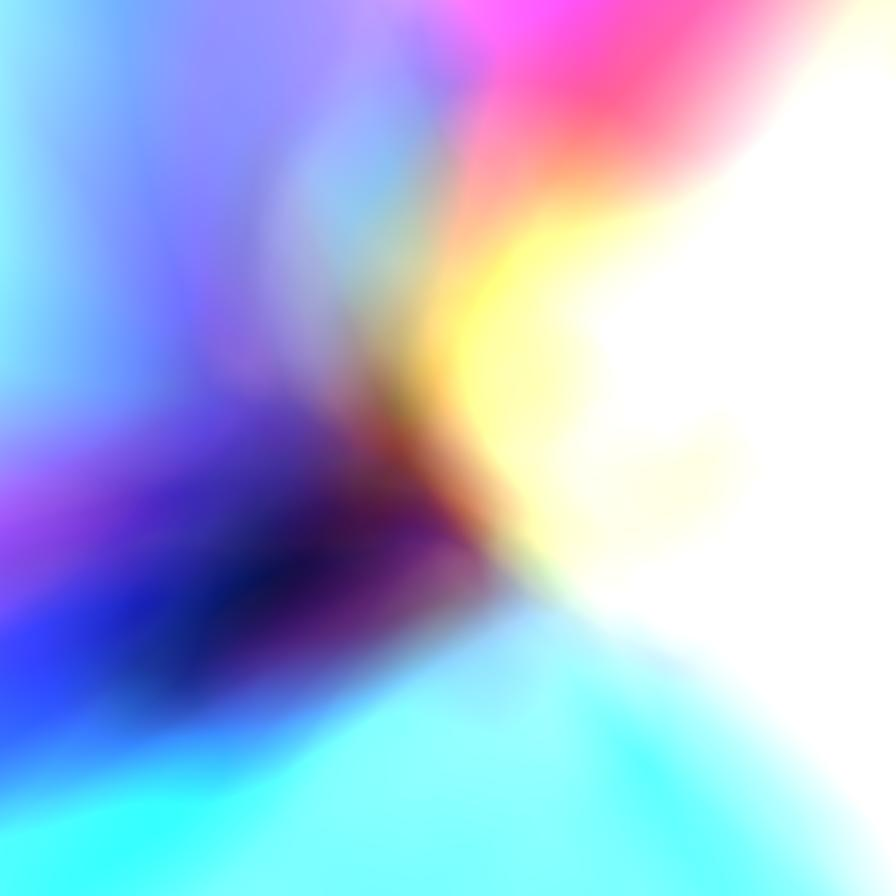

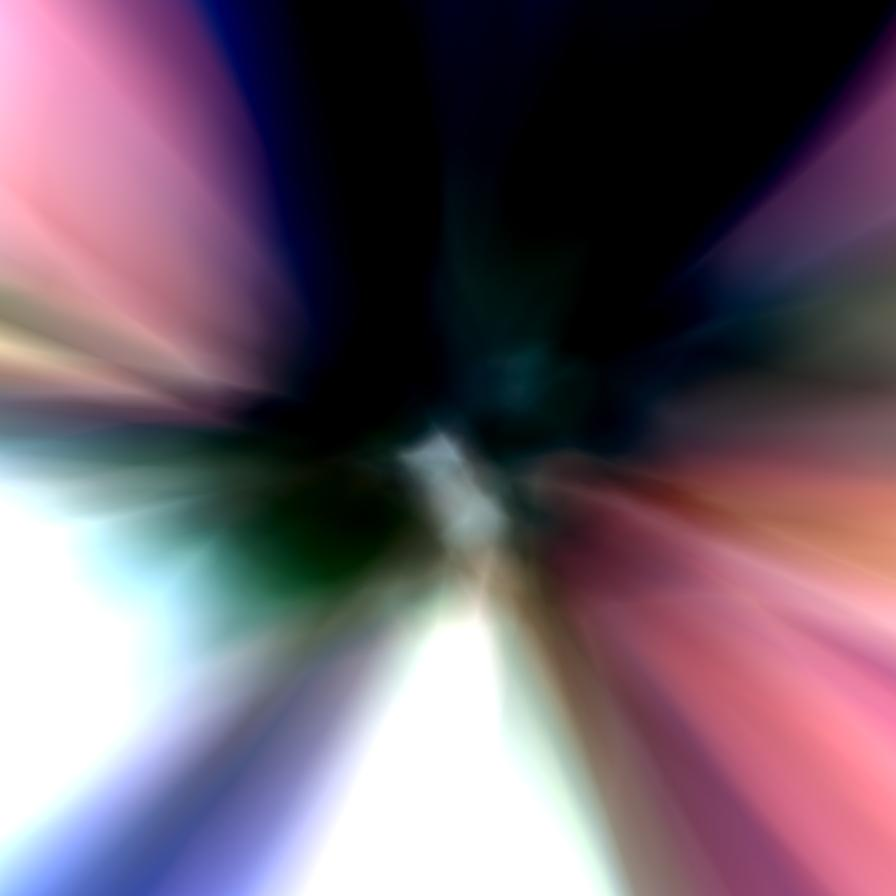

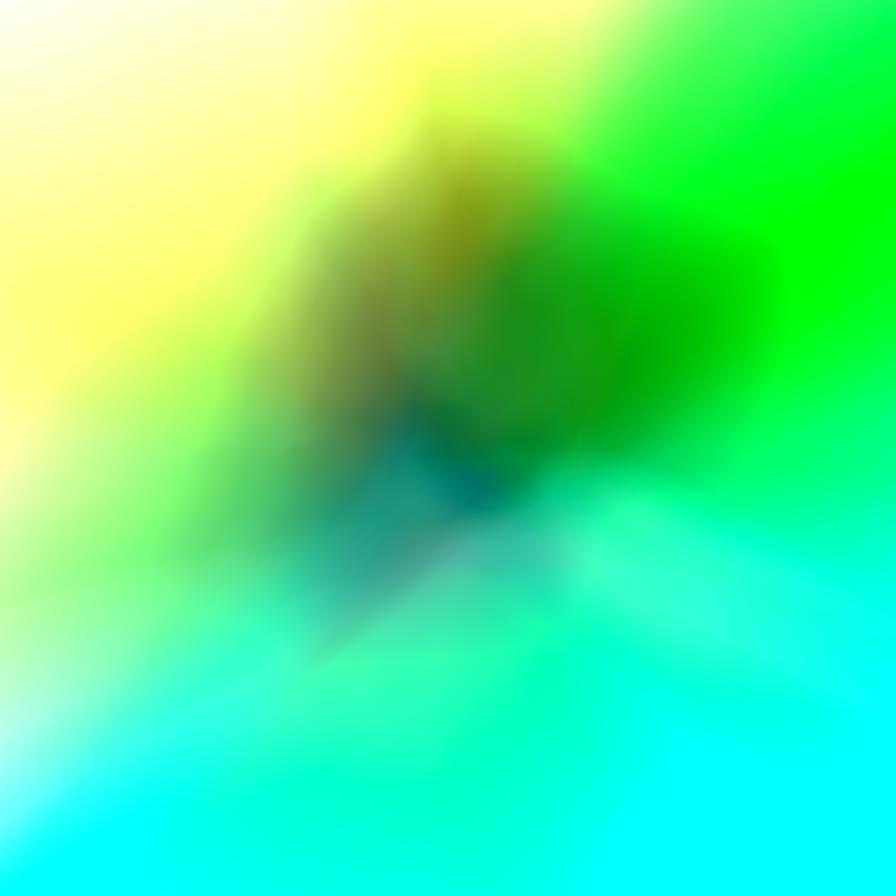

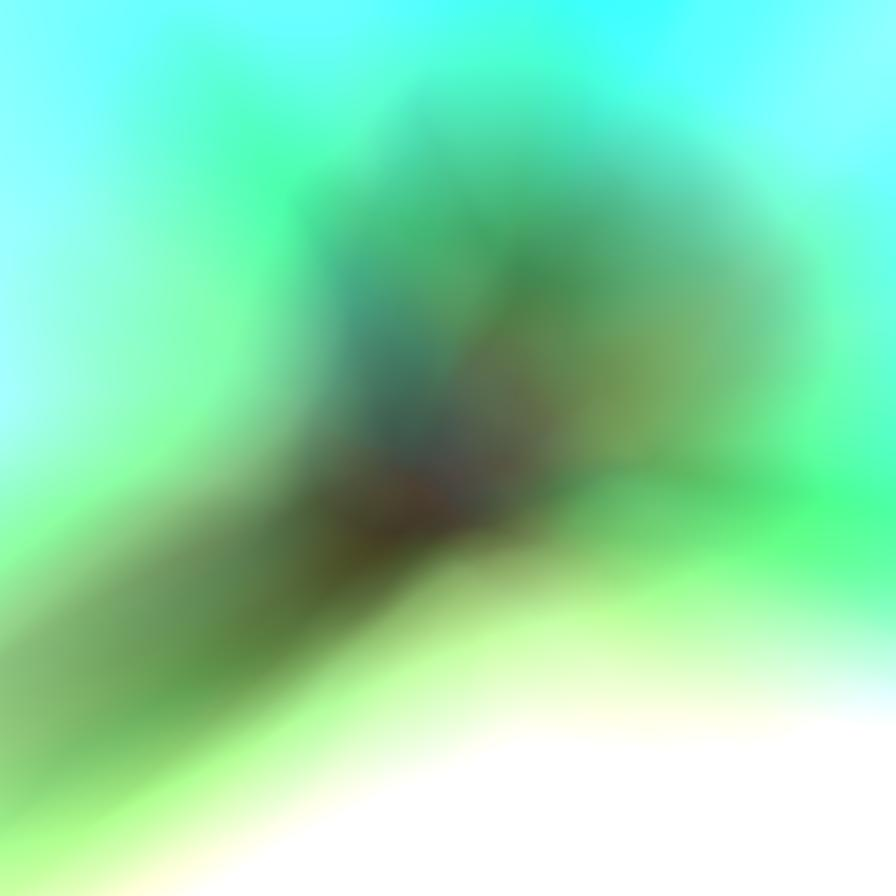

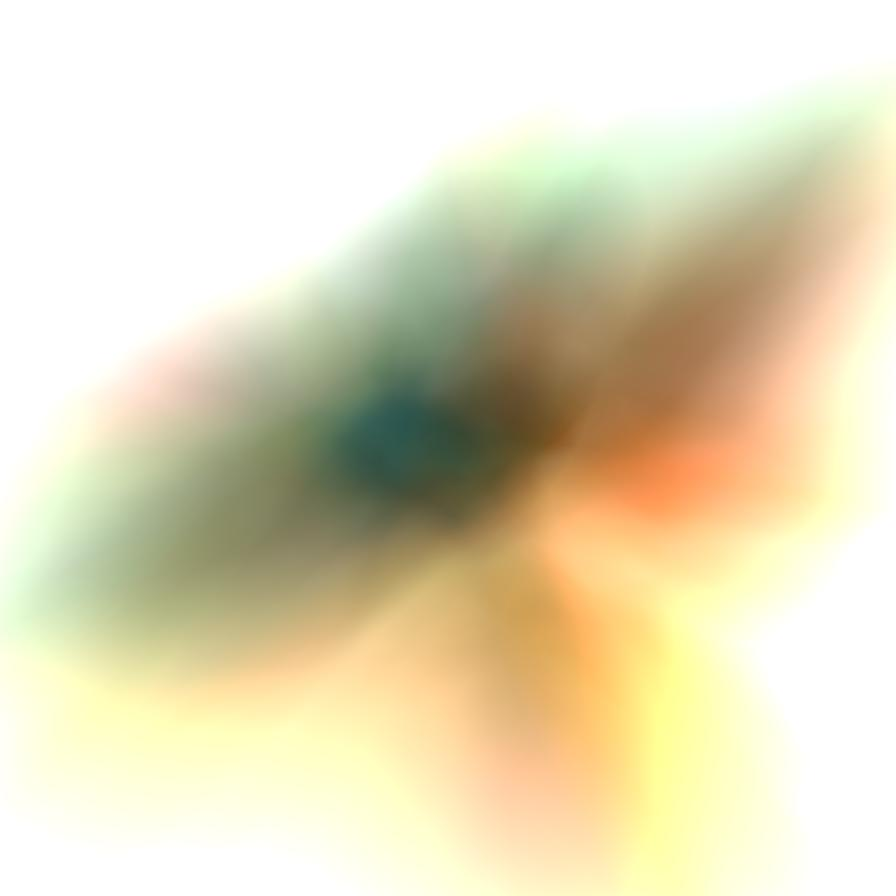

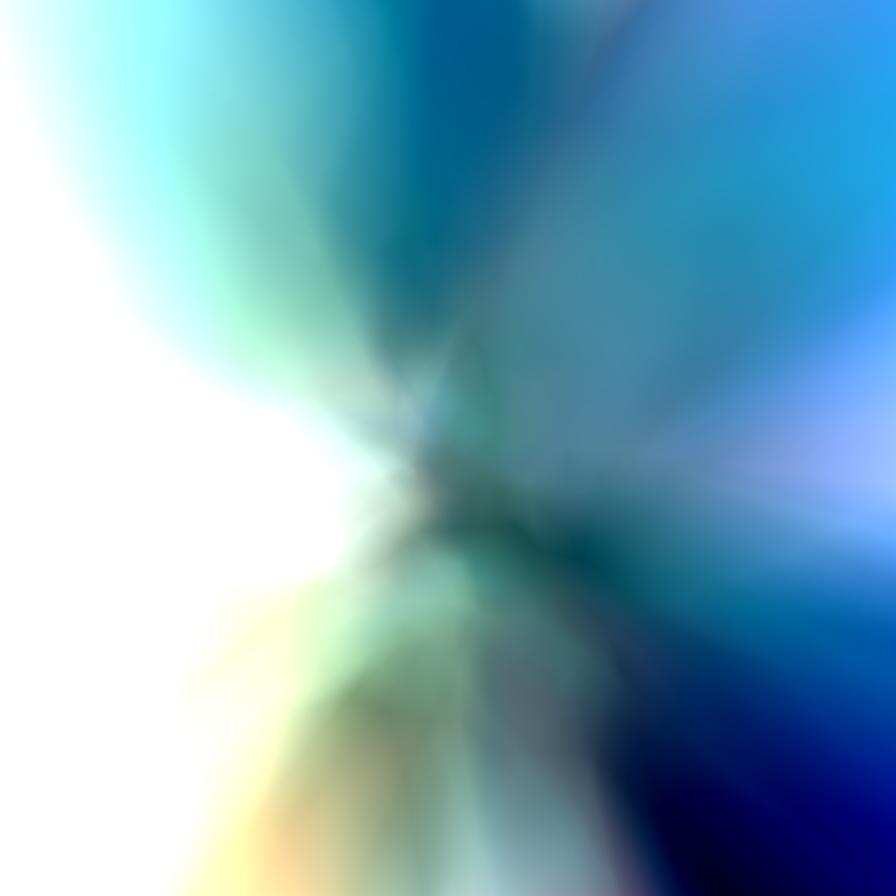

In [35]:

for i in range(7):
    h = forward2(x_data_scaled, 0.4)
    img2 = cuda.to_cpu(h.data)
    img2 = img2.reshape((s,s,3))
    show_img_array((img2 + 0.5)* 255.)